In [1]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [2]:
import numpy as np
np.random.seed(2017) # set random seed value to get reproducible results

In [3]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import RandomSurvivalForest
from tqdm.notebook import tqdm
import statistics

def n_permutations(n, rsf, feat, X, y):
    mean = 0
    std = 0
    for i in range(n):
        X[feat] = np.random.permutation(X[feat].values)        
        scores = cross_validate(rsf, X, y, cv=5)
        mean += scores['test_score'].mean()
        std += statistics.pstdev(scores['test_score'])
    #print('Feature:', feat, ' | Mean Score:', mean/n, ' | Standard Deviation:', std/n)
    return mean/n, std/n

def random_forest(X, y, label):
    # run model and cross validate to get concordance
    rsf = RandomSurvivalForest()
    
    scores = cross_validate(rsf, X, y, cv=5)
    concordance = scores['test_score'].mean()
    print('RF score:', concordance)
    
    # re-train model on full dataset
    rsf = RandomSurvivalForest()
    rsf.fit(X, y)
    
    # calculate feature importances
    feature_importance_rf = pd.DataFrame({'Feature':list(X.columns),})
    feature_importance_rf[label] = 0
        
    for i,row in tqdm(feature_importance_rf.iterrows(), total=feature_importance_rf.shape[0]):
        feat = row['Feature']
        temp_data = X.copy()
        temp_score, _ = n_permutations(5, rsf, feat, temp_data, y)
        percent_change = (concordance - temp_score) / concordance * 100 # percent change
        if percent_change < 0:
            percent_change = 0 # removing feature helped model, should not be reflected in feature importance
        feature_importance_rf.iloc[i, feature_importance_rf.columns.get_loc(label)] = percent_change
    
    # return scores and models
    return rsf, concordance, feature_importance_rf

//anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 368 from PyObject
  return f(*args, **kwds)


In [4]:
def get_lasso_features(X):
    # one-hot encode all variables (except primsev) to get hazards across groups, drop reference group
    features_to_ignore = ['female','nonwhite','unemplmt_cd','primsev_alcohol','primsev_amphetamines','homeless_0_cd',
                          'primsev_cocaine','primsev_marijuana','primsev_opioids','primsev_other']
    lasso_X = X.copy()
    
    for col in lasso_X.columns:
        if col not in features_to_ignore:
            one_hot = pd.get_dummies(lasso_X[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            lasso_X = lasso_X.drop(col,axis = 1)
            lasso_X = lasso_X.join(one_hot)
    #print('Lasso Features:',lasso_X.columns)
    return lasso_X

In [5]:
from sksurv.linear_model import CoxnetSurvivalAnalysis

def lasso_regression(X, y, label):
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    
    scores = cross_validate(rcr, X, y, cv=5)
    concordance = scores['test_score'].mean()
    print('Lasso score:', concordance)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    rcr.fit(X, y)
    
    # feature importances from Lasso
    feature_importance_lasso = pd.DataFrame({'Feature':list(X.columns), 
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    # convert regression coefficients to hazard ratios
    feature_importance_lasso[label] = np.exp(feature_importance_lasso[label])
    # rank by magnitude of deviation from 1
    feature_importance_lasso[label + '_adjusted'] = np.absolute(feature_importance_lasso[label]-1)
    
    return rcr, concordance, feature_importance_lasso

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 14

def get_survival_graph(rsf, rcr, X, lasso_X, y, label, filename):
    pred_surv_rsf = rsf.predict_survival_function(X)    
    pred_surv_rcr = rcr.predict_survival_function(lasso_X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [7]:
# helper function for plotting out ground truth curves

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens == 1]
    counts = relapsed['Illicit_Days'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [8]:
# helper functions for displaying table data
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

Survival Analysis by Severity

In [9]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('../data/data_superset.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days,Illicit_Cens,female,nonwhite,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,SUDSy_0_cd,homeless_0_cd,ncar_cd,TRIg_0_cd,PYS9Sxg_cd,primsev_other,primsev_alcohol,primsev_amphetamines,primsev_cocaine,primsev_marijuana,primsev_opioids,B2a_0g,Address,lat,lng,state_name,county_FIPS,block_FIPS,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,closest,gran,point,pop_deng
0,0,1,6,11520,TX,Laredo,"2386 E. Saunders, Suite 2",2007,78,1,0,1,0,0,2,0,1,1,0,0,2,1,2,1,2,3,0,1,1,0,0,0,0,0,1,0,1,"2386 E. Saunders, Suite 2 , L...",27.530608,-99.472335,Texas,48479.0,4.847900e+14,0,0.0,1.0,0.0,0.0,NaN,0.0,"('27.530608', '-99.472335')",0.0
1,1,2,7,19646,FL,Jacksonville,2671 Huffman Blvd,2011,365,0,0,1,0,0,0,0,2,1,1,0,0,1,2,0,0,1,0,1,1,0,0,1,0,0,0,0,1,"2671 Huffman Blvd , J...",30.298713,-81.504950,Florida,12031.0,1.203101e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('30.298712599999998', '-81.50495040000001')",0.0
2,2,3,8,11738,TX,San Antonio,7703 Floyd Curl Drive,2008,188,0,0,1,0,0,0,0,0,0,0,0,1,2,2,0,0,2,0,1,0,0,0,0,0,0,1,0,1,"7703 Floyd Curl Drive , S...",29.513085,-98.577729,Texas,48029.0,4.802918e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('29.5130847', '-98.57772890000001')",0.0
3,3,7,13,13054,AZ,Tucson,P.O. Box 3308,2007,365,0,0,1,1,1,2,0,0,1,1,1,2,2,2,0,1,3,0,0,0,0,0,0,1,0,0,0,1,"P.O. Box 3308 , T...",32.225221,-110.909508,Arizona,4019.0,4.019002e+13,0,0.0,0.0,0.0,0.0,NaN,1.0,"('32.225221000000005', '-110.909508')",0.0
4,4,10,16,15206,MA,Cambridge,349 Broadway,2008,337,0,1,1,0,0,2,0,2,0,0,0,0,1,2,0,0,1,1,1,1,0,0,0,1,0,0,0,2,"349 Broadway , C...",42.370383,-71.103350,Massachusetts,25017.0,2.501735e+14,0,0.0,0.0,0.0,0.0,NaN,0.0,"('42.3703833', '-71.1033498')",0.0


In [10]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','gran','county_FIPS','block_FIPS',
                'point','closest','%_public_assistanceg','%_dropoutg','%_unemployedg']

df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True) # drops any remaining rows with null values

# uncomment to get CONTROL statistics
#cols_to_drop = ['pop_deng','%_dropoutg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']
#df.drop(columns=cols_to_drop, inplace=True)

df = df.astype(int)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
df.shape

(10683, 32)

In [11]:
df["SUDSy_0_cd"].value_counts()

3    4354
1    3365
2    2964
Name: SUDSy_0_cd, dtype: int64

In [12]:
df.to_csv('../data/data_final.csv')
df.head()

,Illicit_Days,Illicit_Cens,female,nonwhite,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,SUDSy_0_cd,homeless_0_cd,ncar_cd,TRIg_0_cd,PYS9Sxg_cd,primsev_other,primsev_alcohol,primsev_amphetamines,primsev_cocaine,primsev_marijuana,primsev_opioids,B2a_0g,murder_numg,%_povertyg,pop_deng
0,352,0,0,1,0,0,2,2,2,0,2,1,1,1,2,0,1,2,1,1,1,0,0,0,0,0,1,0,2,0,1,0
1,72,1,1,1,0,0,2,0,1,2,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0
2,184,0,0,1,0,1,1,0,0,0,0,0,2,1,2,0,1,2,0,1,0,0,0,0,0,0,1,0,1,1,0,0
3,100,1,1,0,0,0,2,0,1,2,1,1,0,1,2,1,2,2,0,0,1,0,0,1,0,0,0,0,2,0,0,0
4,240,0,0,1,0,0,1,0,1,1,1,0,0,1,1,0,0,2,0,0,1,0,0,0,0,0,1,0,1,0,0,0


Full Population Analysis

In [13]:
from sksurv.util import Surv

predictor_var = 'Illicit_Days'
censoring_var = 'Illicit_Cens'
rf_threshold = 0.5

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(10683, 30) (10683,)


In [14]:
%%time
full_rsf, full_rsf_score, full_rsf_feature_importance = random_forest(X, y, 'ALL')
full_rf_features = full_rsf_feature_importance[full_rsf_feature_importance.ALL >= rf_threshold]['Feature'].tolist()

RF score: 0.6572859682606297



CPU times: user 1h 3min 9s, sys: 11min 55s, total: 1h 15min 4s
Wall time: 2h 46s


In [15]:
%%time
full_lasso_X = get_lasso_features(X[full_rf_features])
full_rcr, full_rcr_score, full_rcr_feature_importance = lasso_regression(full_lasso_X, y, 'ALL')

Lasso score: 0.6368534272609325
CPU times: user 2.2 s, sys: 243 ms, total: 2.44 s
Wall time: 1.61 s


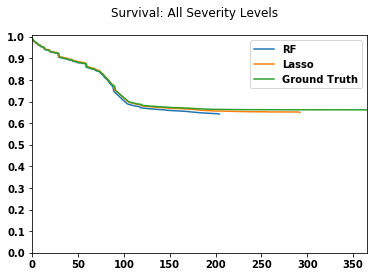

In [16]:
get_survival_graph(full_rsf, full_rcr, X, full_lasso_X, Y, 'Survival: All Severity Levels','../graphs/survival_all.png')

Subclinical Severity Analysis

In [17]:
X = df[df.SUDSy_0_cd == 1]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)
 
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3365, 29) (3365,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
%%time
sub_rsf, sub_rsf_score, sub_rsf_feature_importance = random_forest(X, y, 'SUB')
sub_rf_features = sub_rsf_feature_importance[sub_rsf_feature_importance.SUB >= rf_threshold]['Feature'].tolist()

RF score: 0.6417377538679793



CPU times: user 15min 27s, sys: 1min 31s, total: 16min 59s
Wall time: 17min 16s


In [19]:
%%time
sub_lasso_X = get_lasso_features(X[sub_rf_features])
sub_rcr, sub_rcr_score, sub_rcr_feature_importance = lasso_regression(sub_lasso_X, y, 'SUB')

Lasso score: 0.6331286452167051
CPU times: user 652 ms, sys: 51.8 ms, total: 704 ms
Wall time: 481 ms


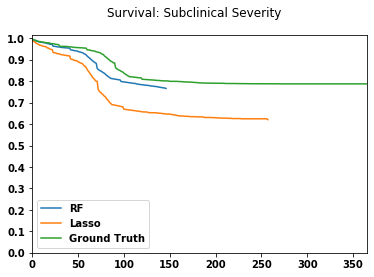

In [20]:
get_survival_graph(sub_rsf, sub_rcr, X, sub_lasso_X, Y, 'Survival: Subclinical Severity','../graphs/survival_sub.png')

Mild Severity Analysis

In [21]:
X = df[df.SUDSy_0_cd == 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2964, 29) (2964,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
%%time
mild_rsf, mild_rsf_score, mild_rsf_feature_importance = random_forest(X, y, 'MILD')
mild_rf_features = mild_rsf_feature_importance[mild_rsf_feature_importance.MILD >= rf_threshold]['Feature'].tolist()

RF score: 0.570564015561821



CPU times: user 14min 48s, sys: 1min 39s, total: 16min 27s
Wall time: 16min 40s


In [23]:
%%time
mild_lasso_X = get_lasso_features(X[mild_rf_features])
mild_rcr, mild_rcr_score, mild_rcr_feature_importance = lasso_regression(mild_lasso_X, y, 'MILD')

Lasso score: 0.5517191643674114
CPU times: user 709 ms, sys: 55.3 ms, total: 764 ms
Wall time: 522 ms


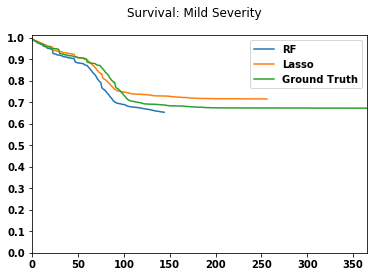

In [24]:
get_survival_graph(mild_rsf, mild_rcr, X, mild_lasso_X, Y, 'Survival: Mild Severity','../graphs/survival_mild.png')

Severe Severity Analysis

In [25]:
X = df[df.SUDSy_0_cd == 3]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0_cd'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(4354, 29) (4354,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
%%time
severe_rsf, severe_rsf_score, severe_rsf_feature_importance = random_forest(X, y, 'SEVERE')
severe_rf_features = severe_rsf_feature_importance[severe_rsf_feature_importance.SEVERE >= rf_threshold]['Feature'].tolist()

RF score: 0.608128065237371



CPU times: user 21min 35s, sys: 2min 13s, total: 23min 49s
Wall time: 24min 17s


In [27]:
severe_rsf_feature_importance[severe_rsf_feature_importance.SEVERE != 0]

,Feature,SEVERE
1,nonwhite,0.544771
2,unemplmt_cd,0.129864
4,gvsg_cd,0.023818
5,CWSg_0_cd,0.317338
6,dssg_0_cd,0.276900
7,epsg_0_cd,0.097215
8,adhdg_0_cd,0.075068
10,cjsig_0_cd,0.016976
11,lrig_0_cd,0.261656
12,srig_0_cd,0.479667


In [28]:
%%time
severe_lasso_X = get_lasso_features(X[severe_rf_features])
severe_rcr, severe_rcr_score, severe_rcr_feature_importance = lasso_regression(severe_lasso_X, y, 'SEVERE')

Lasso score: 0.5689867368001877
CPU times: user 807 ms, sys: 60.5 ms, total: 868 ms
Wall time: 602 ms


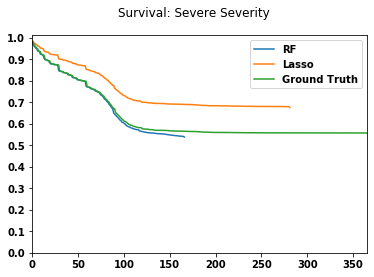

In [29]:
get_survival_graph(severe_rsf, severe_rcr, X, severe_lasso_X, Y, 'Survival: Severe Severity','../graphs/survival_severe.png')

Performance Statistics

In [30]:
# concordance index
scores = {'MODEL': ['Random Forest','Lasso','Dataset Size'], 
          'SUB': [sub_rsf_score,sub_rcr_score,int(sub_lasso_X.shape[0])],
          'MILD': [mild_rsf_score,mild_rcr_score,int(mild_lasso_X.shape[0])],
          'SEVERE': [severe_rsf_score,severe_rcr_score,int(severe_lasso_X.shape[0])],
          'FULL': [full_rsf_score,full_rcr_score,int(full_lasso_X.shape[0])]
         }
overall_concordance = pd.DataFrame(data=scores).round(4)
overall_concordance

,MODEL,SUB,MILD,SEVERE,FULL
0,Random Forest,0.6417,0.5706,0.6081,0.6573
1,Lasso,0.6331,0.5517,0.5690,0.6369
2,Dataset Size,3365.0000,2964.0000,4354.0000,10683.0000


Feature Importance - Random Forest

In [31]:
overall_feature_importance_rf = pd.merge(sub_rsf_feature_importance, mild_rsf_feature_importance, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_rsf_feature_importance, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,female,0.029786,0.000000,0.000000
1,nonwhite,0.000000,0.043250,0.544771
2,unemplmt_cd,0.000000,0.397802,0.129864
3,prsatx_cd,0.000000,0.864638,0.000000
4,gvsg_cd,0.000000,0.421522,0.023818
5,CWSg_0_cd,0.000000,0.000000,0.317338
6,dssg_0_cd,0.000000,0.000000,0.276900
,Feature,SUB,MILD,SEVERE
7,epsg_0_cd,0.000000,0.000000,0.097215
8,adhdg_0_cd,0.000000,0.315237,0.075068


In [32]:
sub_feature_importance_rf = sub_rsf_feature_importance[sub_rsf_feature_importance.SUB != 0]
mild_feature_importance_rf = mild_rsf_feature_importance[mild_rsf_feature_importance.MILD != 0]
severe_feature_importance_rf = severe_rsf_feature_importance[severe_rsf_feature_importance.SEVERE != 0]

feature_importance_rf = pd.merge(sub_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
feature_importance_rf = pd.merge(feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,female,0.029786,0.000000,0.000000
1,cjsig_0_cd,1.318725,1.182274,0.016976
2,r4ag_0_cd,0.891077,1.606254,1.041398
3,B2a_0g,1.056852,0.863960,1.859121
4,murder_numg,2.183811,0.528912,0.150110
5,%_povertyg,1.149838,0.552240,0.854908
,Feature,SUB,MILD,SEVERE
6,nonwhite,0.0,0.043250,0.544771
7,unemplmt_cd,0.0,0.397802,0.129864
8,prsatx_cd,0.0,0.864638,0.000000


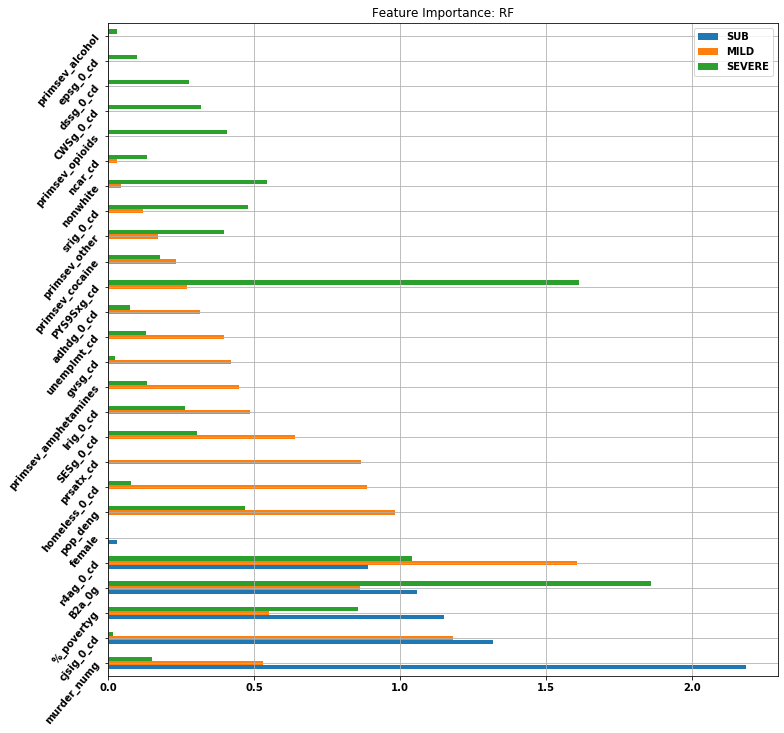

In [33]:
# feature importance for rf across all ages
feature_importance = pd.DataFrame({'SUB': feature_importance_rf['SUB'].tolist(),
                   'MILD': feature_importance_rf['MILD'].tolist(),
                   'SEVERE': feature_importance_rf['SEVERE'].tolist()},
                  index=feature_importance_rf['Feature'].tolist())
# John asked to sort this graph by MILD
feature_importance.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = feature_importance.plot.barh(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance.png', bbox_inches='tight')

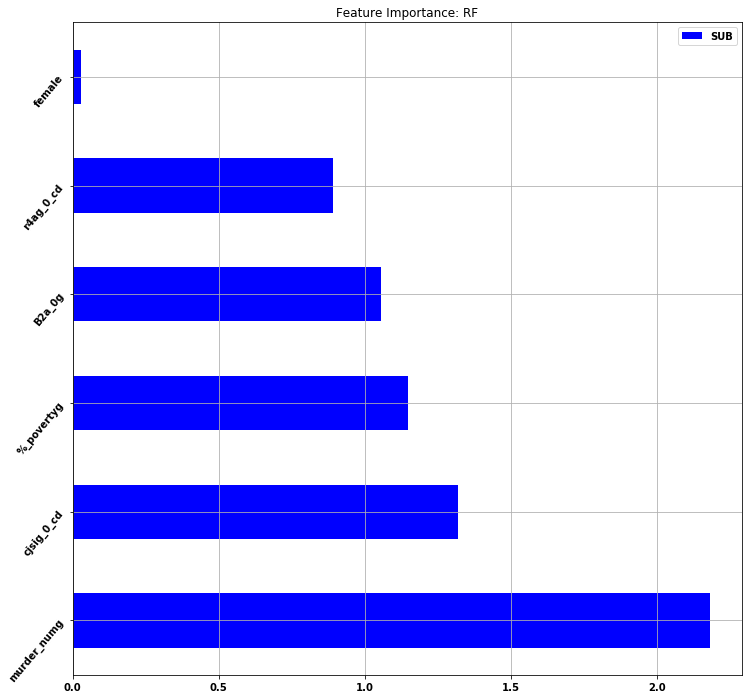

In [34]:
# feature importance for rf across all ages
feature_importance_sub = pd.DataFrame({'SUB': feature_importance_rf['SUB'].tolist()},
                  index=feature_importance_rf['Feature'].tolist())
feature_importance_sub = feature_importance_sub[feature_importance_sub.SUB != 0]
# John asked to sort this graph by MILD
feature_importance_sub.sort_values(by=['SUB'], ascending=False, inplace=True)
ax = feature_importance_sub.plot.barh(rot=50, figsize=(12, 12), color='blue')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance_sub.png', bbox_inches='tight')

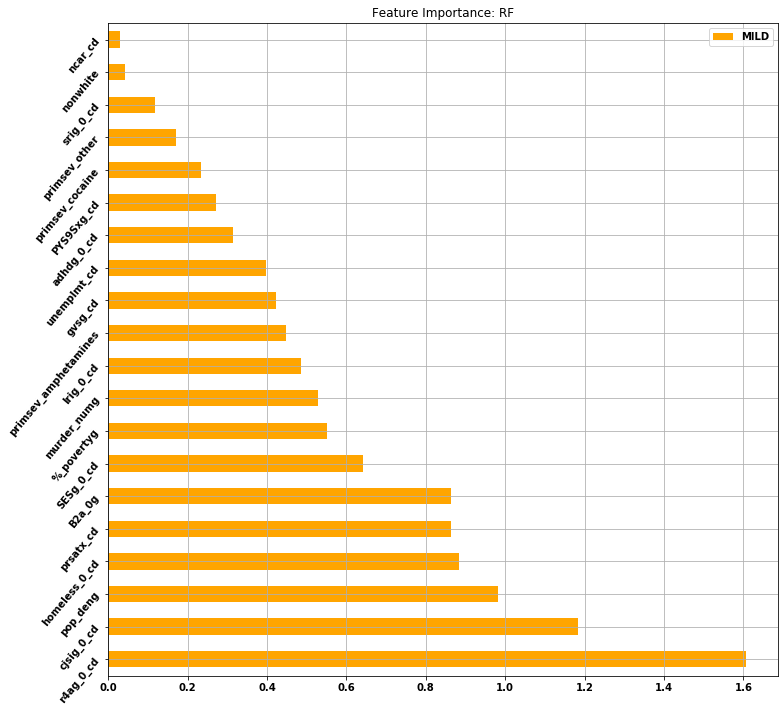

In [35]:
# feature importance for rf across all ages
feature_importance_mild = pd.DataFrame({'MILD': feature_importance_rf['MILD'].tolist()},
                  index=feature_importance_rf['Feature'].tolist())
feature_importance_mild = feature_importance_mild[feature_importance_mild.MILD != 0]
# John asked to sort this graph by MILD
feature_importance_mild.sort_values(by=['MILD'], ascending=False, inplace=True)
ax = feature_importance_mild.plot.barh(rot=50, figsize=(12, 12), color='orange')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance_mild.png', bbox_inches='tight')

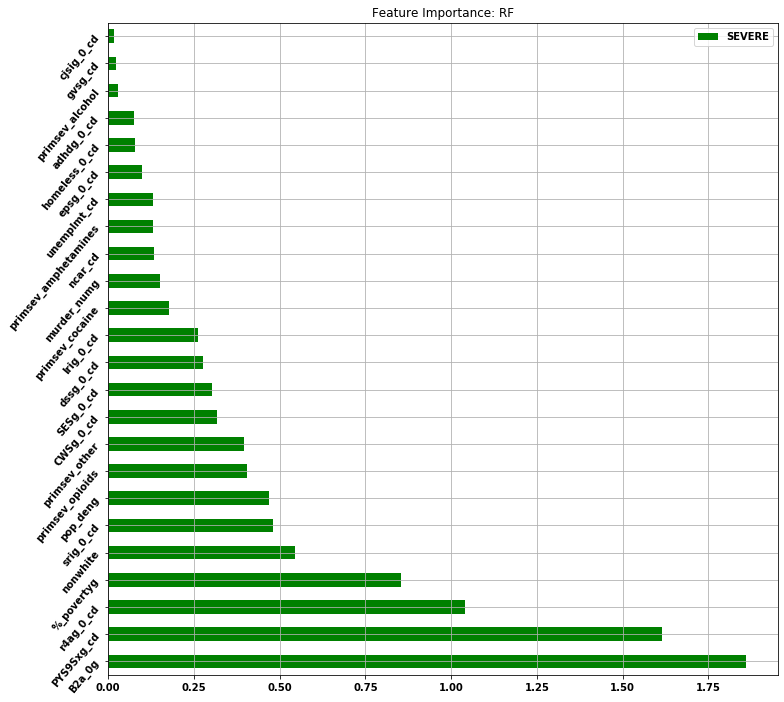

In [36]:
# feature importance for rf across all ages
feature_importance_severe = pd.DataFrame({'SEVERE': feature_importance_rf['SEVERE'].tolist()},
                  index=feature_importance_rf['Feature'].tolist())
feature_importance_severe = feature_importance_severe[feature_importance_severe.SEVERE != 0]
# John asked to sort this graph by MILD
feature_importance_severe.sort_values(by=['SEVERE'], ascending=False, inplace=True)
ax = feature_importance_severe.plot.barh(rot=50, figsize=(12, 12), color='green')
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('../graphs/feature_importance_severe.png', bbox_inches='tight')

Feature Importance - Lasso

In [37]:
overall_feature_importance_lasso = pd.merge(sub_rcr_feature_importance, \
                                            mild_rcr_feature_importance, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_rcr_feature_importance, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
0,cjsig_0_cd_0,0.919541,0.080459,0.937739,0.062261,0.000000,0.000000
1,cjsig_0_cd_2,1.080509,0.080509,0.996816,0.003184,0.000000,0.000000
2,r4ag_0_cd_0,0.982394,0.017606,0.881820,0.118180,0.830398,0.169602
3,r4ag_0_cd_2,1.198671,0.198671,0.999719,0.000281,1.007858,0.007858
4,B2a_0g_0,0.947657,0.052343,0.986232,0.013768,1.000105,0.000105
5,B2a_0g_2,1.135208,0.135208,0.972881,0.027119,0.912271,0.087729
6,murder_numg_0,1.452005,0.452005,1.000000,0.000000,0.000000,0.000000
7,murder_numg_2,1.000003,0.000003,0.951514,0.048486,0.000000,0.000000
8,%_povertyg_0,0.946421,0.053579,0.985930,0.014070,0.998190,0.001810
,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted


In [38]:
sub_feature_importance_lasso = sub_rcr_feature_importance.nlargest(10,['SUB_adjusted'])
mild_feature_importance_lasso = mild_rcr_feature_importance.nlargest(10,['MILD_adjusted'])
severe_feature_importance_lasso = severe_rcr_feature_importance.nlargest(10,['SEVERE_adjusted'])

top10_feature_importance_lasso = pd.merge(sub_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
top10_feature_importance_lasso = pd.merge(top10_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
top10_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(top10_feature_importance_lasso, 2)

,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
0,murder_numg_0,1.452005,0.452005,0.000000,0.000000,0.000000,0.000000
1,r4ag_0_cd_2,1.198671,0.198671,0.000000,0.000000,1.007858,0.007858
2,B2a_0g_2,1.135208,0.135208,0.972881,0.027119,0.912271,0.087729
3,cjsig_0_cd_2,1.080509,0.080509,0.000000,0.000000,0.000000,0.000000
4,cjsig_0_cd_0,0.919541,0.080459,0.937739,0.062261,0.000000,0.000000
5,%_povertyg_0,0.946421,0.053579,0.985930,0.014070,0.998190,0.001810
6,B2a_0g_0,0.947657,0.052343,0.986232,0.013768,1.000105,0.000105
7,r4ag_0_cd_0,0.982394,0.017606,0.881820,0.118180,0.830398,0.169602
,Feature,SUB,SUB_adjusted,MILD,MILD_adjusted,SEVERE,SEVERE_adjusted
8,murder_numg_2,1.000003,0.000003,0.951514,0.048486,0.000000,0.000000


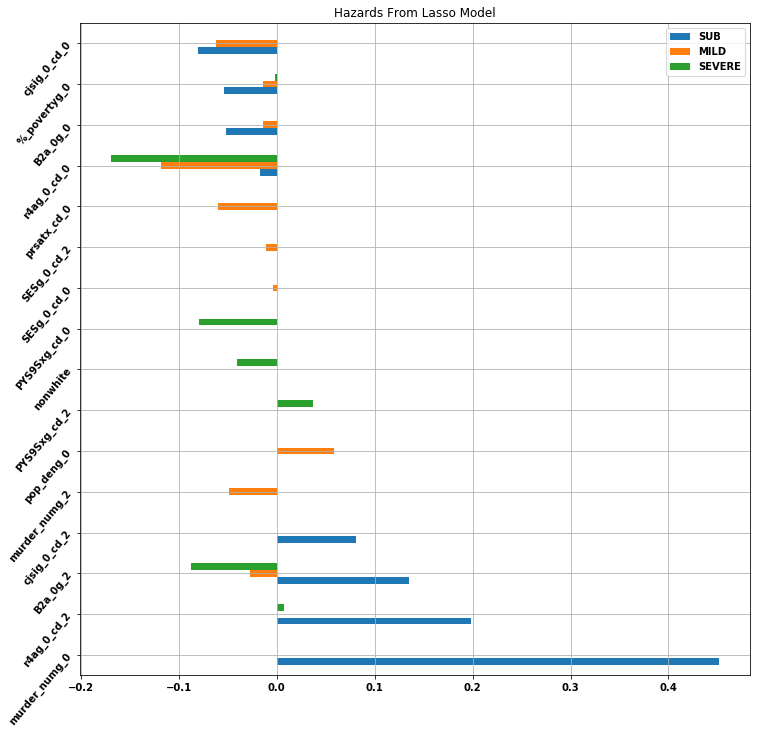

In [39]:
top10_feature_importance_lasso['SUB_minus1'] = top10_feature_importance_lasso['SUB'] - 1
top10_feature_importance_lasso['MILD_minus1'] = top10_feature_importance_lasso['MILD'] - 1
top10_feature_importance_lasso['SEVERE_minus1'] = top10_feature_importance_lasso['SEVERE'] - 1

haz_df = pd.DataFrame({'SUB': top10_feature_importance_lasso['SUB_minus1'].tolist(),
                   'MILD': top10_feature_importance_lasso['MILD_minus1'].tolist(),
                   'SEVERE': top10_feature_importance_lasso['SEVERE_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_df = haz_df.replace(-1, 0)
haz_df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = haz_df.plot.barh(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso.png', bbox_inches='tight')

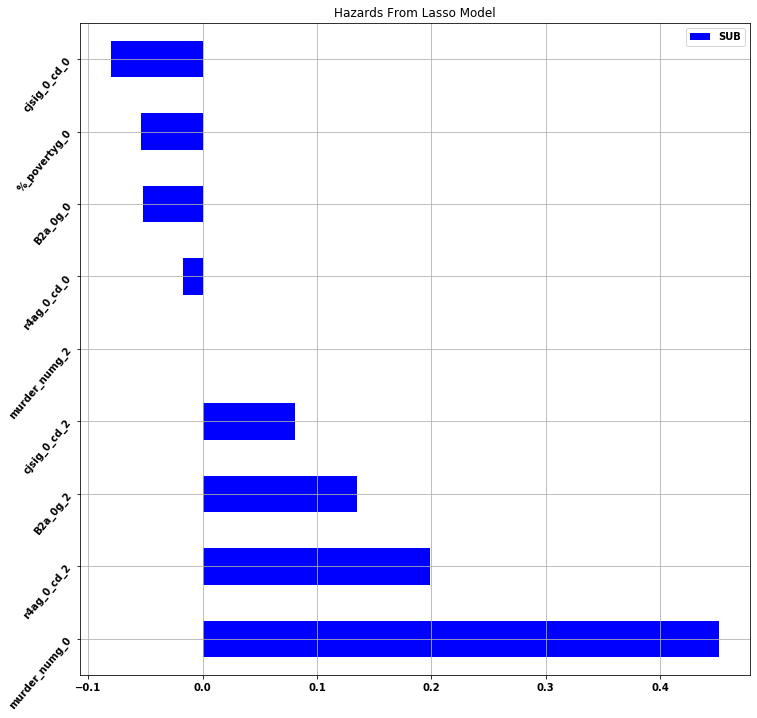

In [40]:
haz_sub = pd.DataFrame({'SUB': top10_feature_importance_lasso['SUB_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_sub = haz_sub[haz_sub.SUB != -1]
haz_sub.sort_values(by=['SUB'], ascending=False, inplace=True)

ax = haz_sub.plot.barh(rot=50, figsize=(12, 12), color='blue')
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso_sub.png', bbox_inches='tight')

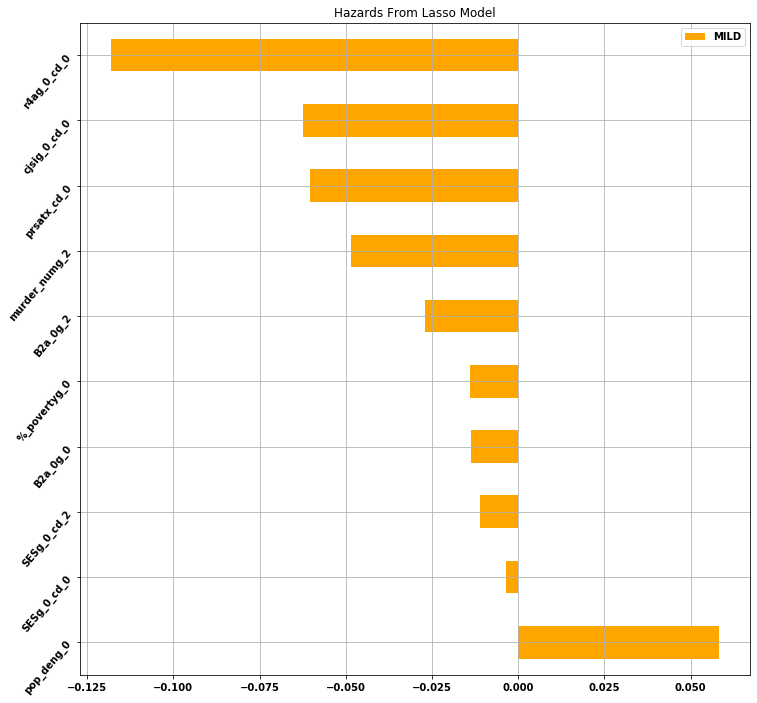

In [41]:
haz_mild = pd.DataFrame({'MILD': top10_feature_importance_lasso['MILD_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_mild = haz_mild[haz_mild.MILD != -1]
haz_mild.sort_values(by=['MILD'], ascending=False, inplace=True)

ax = haz_mild.plot.barh(rot=50, figsize=(12, 12), color='orange')
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso_mild.png', bbox_inches='tight')

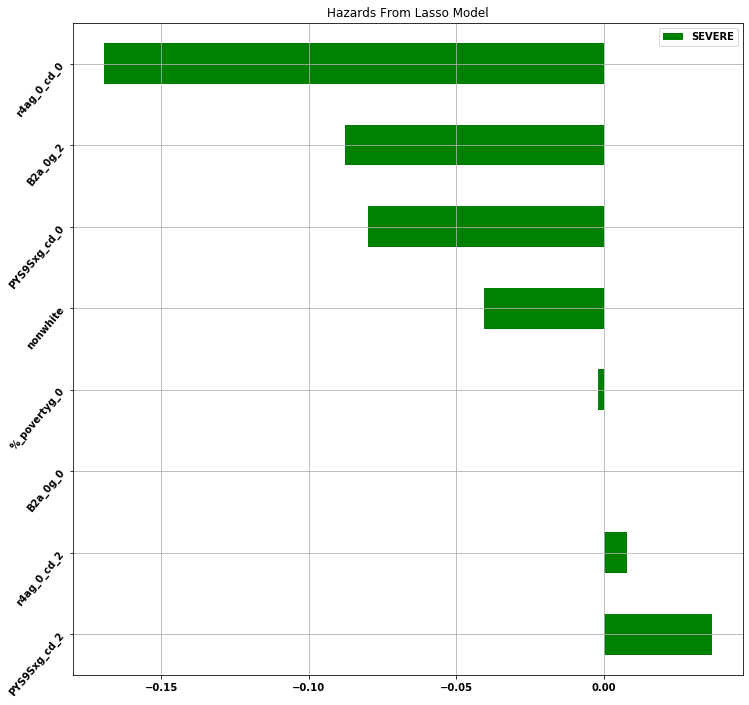

In [42]:
haz_severe = pd.DataFrame({'SEVERE': top10_feature_importance_lasso['SEVERE_minus1'].tolist()},
                  index=top10_feature_importance_lasso['Feature'].tolist())
haz_severe = haz_severe[haz_severe.SEVERE != -1]
haz_severe.sort_values(by=['SEVERE'], ascending=False, inplace=True)

ax = haz_severe.plot.barh(rot=50, figsize=(12, 12), color='green')
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('../graphs/hazards_lasso_severe.png', bbox_inches='tight')

Saving Feature Importance Spreadsheet...

In [43]:
def find_lasso_winner(feat, lasso_0, lasso_2):
    if lasso_0 == 0 and lasso_2 == 0: # rf deemed unimportant
        return pd.Series((0, ''))
    bin_features = ['female','nonwhite','unemplmt_cd','primsev_alcohol','primsev_amphetamines','homeless_0_cd',
                    'primsev_cocaine','primsev_marijuana','primsev_opioids','primsev_other']
    if feat in bin_features:
        return pd.Series((lasso_0, 2))
    elif lasso_0 == 0:
        return pd.Series((lasso_2, 2))
    elif lasso_2 == 0:
        return pd.Series((lasso_0, 0))
    elif abs(lasso_0-1) > abs(lasso_2-1):
        return pd.Series((lasso_0, '0'))
    else:
        return pd.Series((lasso_2, '2'))

In [44]:
sub_cmn_feat = sub_rsf_feature_importance.copy()
sub_cmn_feat['Lasso_0'] = 0.0
sub_cmn_feat['Lasso_2'] = 0.0
sub_lasso_feat = sub_rcr_feature_importance.copy()
for i,row_rf in tqdm(sub_cmn_feat.iterrows(), total=sub_cmn_feat.shape[0]):
    rf_feat = row_rf['Feature']
    for j,row_lasso in sub_lasso_feat.iterrows():
        lasso_feat = row_lasso['Feature']
        if lasso_feat.startswith(rf_feat):
            if lasso_feat[-1] == '2':
                sub_cmn_feat.set_value(i, 'Lasso_2', row_lasso['SUB'])
            else:
                sub_cmn_feat.set_value(i, 'Lasso_0', row_lasso['SUB'])
sub_cmn_feat.sort_values(by='SUB', inplace=True, ascending=False)
sub_cmn_feat[['lasso_max','lasso_max_level']] = sub_cmn_feat.apply(lambda x: find_lasso_winner(x['Feature'], x['Lasso_0'], x['Lasso_2']), axis=1)
sub_cmn_feat

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


,Feature,SUB,Lasso_0,Lasso_2,lasso_max,lasso_max_level
26,murder_numg,2.183811,1.452005,1.000003,1.452005,0
10,cjsig_0_cd,1.318725,0.919541,1.080509,1.080509,2
27,%_povertyg,1.149838,0.946421,0.000000,0.946421,0
25,B2a_0g,1.056852,0.947657,1.135208,1.135208,2
14,r4ag_0_cd,0.891077,0.982394,1.198671,1.198671,2
0,female,0.029786,0.000000,0.000000,0.000000,
6,dssg_0_cd,0.000000,0.000000,0.000000,0.000000,
18,PYS9Sxg_cd,0.000000,0.000000,0.000000,0.000000,
2,unemplmt_cd,0.000000,0.000000,0.000000,0.000000,
3,prsatx_cd,0.000000,0.000000,0.000000,0.000000,


In [45]:
mild_cmn_feat = mild_rsf_feature_importance.copy()
mild_cmn_feat['Lasso_0'] = 0.0
mild_cmn_feat['Lasso_2'] = 0.0
mild_lasso_feat = mild_rcr_feature_importance.copy()
for i,row_rf in tqdm(mild_cmn_feat.iterrows(), total=mild_cmn_feat.shape[0]):
    rf_feat = row_rf['Feature']
    for j,row_lasso in mild_lasso_feat.iterrows():
        lasso_feat = row_lasso['Feature']
        if lasso_feat.startswith(rf_feat):
            if lasso_feat[-1] == '2':
                mild_cmn_feat.set_value(i, 'Lasso_2', row_lasso['MILD'])
            else:
                mild_cmn_feat.set_value(i, 'Lasso_0', row_lasso['MILD'])
mild_cmn_feat.sort_values(by='MILD', inplace=True, ascending=False)
mild_cmn_feat[['lasso_max','lasso_max_level']] = mild_cmn_feat.apply(lambda x: find_lasso_winner(x['Feature'], x['Lasso_0'], x['Lasso_2']), axis=1)
mild_cmn_feat

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


,Feature,MILD,Lasso_0,Lasso_2,lasso_max,lasso_max_level
14,r4ag_0_cd,1.606254,0.881820,0.999719,0.881820,0
10,cjsig_0_cd,1.182274,0.937739,0.996816,0.937739,0
28,pop_deng,0.982371,1.058354,1.000000,1.058354,0
15,homeless_0_cd,0.884715,1.000000,0.000000,1.000000,2
3,prsatx_cd,0.864638,0.939596,0.000000,0.939596,0
25,B2a_0g,0.863960,0.986232,0.972881,0.972881,2
13,SESg_0_cd,0.640583,0.996608,0.988813,0.988813,2
27,%_povertyg,0.552240,0.985930,0.000000,0.985930,0
26,murder_numg,0.528912,1.000000,0.951514,0.951514,2
11,lrig_0_cd,0.484759,0.000000,0.000000,0.000000,


In [46]:
severe_cmn_feat = severe_rsf_feature_importance.copy()
severe_cmn_feat['Lasso_0'] = 0.0
severe_cmn_feat['Lasso_2'] = 0.0
severe_lasso_feat = severe_rcr_feature_importance.copy()
for i,row_rf in tqdm(severe_cmn_feat.iterrows(), total=severe_cmn_feat.shape[0]):
    rf_feat = row_rf['Feature']
    for j,row_lasso in severe_lasso_feat.iterrows():
        lasso_feat = row_lasso['Feature']
        if lasso_feat.startswith(rf_feat):
            if lasso_feat[-1] == '2':
                severe_cmn_feat.set_value(i, 'Lasso_2', row_lasso['SEVERE'])
            else:
                severe_cmn_feat.set_value(i, 'Lasso_0', row_lasso['SEVERE'])
severe_cmn_feat.sort_values(by='SEVERE', inplace=True, ascending=False)
severe_cmn_feat[['lasso_max','lasso_max_level']] = severe_cmn_feat.apply(lambda x: find_lasso_winner(x['Feature'], x['Lasso_0'], x['Lasso_2']), axis=1)
severe_cmn_feat

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


,Feature,SEVERE,Lasso_0,Lasso_2,lasso_max,lasso_max_level
25,B2a_0g,1.859121,1.000105,0.912271,0.912271,2
18,PYS9Sxg_cd,1.613411,0.920113,1.036856,0.920113,0
14,r4ag_0_cd,1.041398,0.830398,1.007858,0.830398,0
27,%_povertyg,0.854908,0.998190,0.000000,0.998190,0
1,nonwhite,0.544771,0.959407,0.000000,0.959407,2
12,srig_0_cd,0.479667,0.000000,0.000000,0.000000,
28,pop_deng,0.469254,0.000000,0.000000,0.000000,
24,primsev_opioids,0.405797,0.000000,0.000000,0.000000,
19,primsev_other,0.395829,0.000000,0.000000,0.000000,
5,CWSg_0_cd,0.317338,0.000000,0.000000,0.000000,


In [47]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('../graphs/common_feature_analysis.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
sub_cmn_feat.to_excel(writer, sheet_name='Subclinical')
mild_cmn_feat.to_excel(writer, sheet_name='Mild')
severe_cmn_feat.to_excel(writer, sheet_name='Severe')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [50]:
%%bash
jupyter nbconvert --to html ./survival_analysis.ipynb
mv survival_analysis.html ../graphs/survival_analysis_5.html

[NbConvertApp] Converting notebook ./survival_analysis.ipynb to html
[NbConvertApp] Writing 898420 bytes to ./survival_analysis.html


In [49]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 177 minutes 17 seconds ---
